In [1]:
import pandas as pd
import numpy as np
import rioxarray
import json, os

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE

In [2]:
seed = 42
verbose = False
details = False

In [3]:
INVASIVE_BIRDS_PATH = 'Datasets/Machine Learning/1km Rasters/Birds'
# Use this if using coordinates as separate columns
# df_1km = pd.read_csv('Datasets/Machine Learning/Dataframes/1km_All_Birds_DF.csv')

# Use this if using coordinates as indices
df_1km = pd.read_csv('Datasets/Machine Learning/Dataframes/1km_All_Birds_DF.csv', index_col=[0,1])

total_birds = (df_1km['Occurrence']==1).sum()
df_dicts = []

for file in os.listdir(INVASIVE_BIRDS_PATH):
    filename = os.fsdecode(file)
    if not filename.endswith('.tif') or filename.endswith('All_Invasive_Birds_1km.tif') :
         continue



    bird_name = filename[:-4].replace('_', ' ')

    bird_dataset = rioxarray.open_rasterio(f'{INVASIVE_BIRDS_PATH}/{file}')
    bird_dataset.name = 'data'
    bird_df = bird_dataset.squeeze().drop("spatial_ref").drop("band").to_dataframe()

    # Check if index matches
    if not df_1km.index.equals(bird_df.index):
        print('Warning: Index does not match')
        continue

    bird_df['Occurrence'] = [0 if x == -1 else 1 for x in bird_df['data']]
    bird_df = df_1km.drop(columns='Occurrence').join(bird_df.drop(columns='data'))
    
    bird_dict = {'name' : bird_name, 'dataframe' : bird_df }
    df_dicts.append(bird_dict)
    display(bird_df.sample(5))


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
694500.0,477500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
210500.0,677500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
759500.0,544500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
72500.0,623500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
149500.0,621500.0,1,0,39,49,0,0,0,0,0,0,...,1.724291e+01,6.812263e+00,4.734298e+00,6.626553e+00,1.239359e+01,4.734772e+00,9.442502e+00,2.668877e+00,1.324458e+01,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
974500.0,21500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1232500.0,338500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
893500.0,529500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
430500.0,517500.0,0,0,69,19,0,0,0,0,0,0,...,1.966602e+01,3.800922e+00,4.639413e+00,6.180963e+00,1.164640e+01,3.954313e+00,7.839109e+00,5.947833e+00,1.104375e+01,0
591500.0,188500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
757500.0,544500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
281500.0,107500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
190500.0,514500.0,0,0,0,0,0,0,0,0,0,0,...,2.709699e-02,2.460739e-03,6.458480e-03,-3.400000e+38,8.164858e-03,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
112500.0,327500.0,6,0,0,85,0,0,3,0,0,0,...,4.458077e-01,6.389004e-02,2.545906e-01,-3.400000e+38,1.918320e-01,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1066500.0,22500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
944500.0,263500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
432500.0,528500.0,0,0,89,9,0,0,0,0,0,0,...,2.478887e+01,2.057126e+00,5.689130e+00,2.279771e+00,1.777105e+01,1.451457e+00,7.865818e+00,7.642649e+00,1.022006e+01,0
587500.0,533500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
651500.0,616500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
340500.0,674500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
549500.0,249500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
44500.0,119500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
779500.0,579500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
950500.0,143500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1255500.0,208500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
954500.0,390500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
539500.0,617500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1222500.0,101500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
703500.0,465500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1061500.0,448500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
377500.0,604500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
157500.0,50500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
451500.0,211500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
33500.0,64500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
101500.0,366500.0,3,0,26,36,0,4,0,0,0,0,...,9.570961e+00,1.463823e+00,2.848618e+00,1.365802e+00,4.433976e+00,6.950105e-01,3.528992e+00,6.812985e-01,2.624046e+00,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
817500.0,106500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
849500.0,473500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
337500.0,125500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
600500.0,218500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
75500.0,369500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1145500.0,49500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1176500.0,540500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
133500.0,558500.0,24,0,0,72,0,0,0,0,0,0,...,2.749420e-01,2.871193e-02,1.061012e-01,-3.400000e+38,8.849488e-02,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
735500.0,159500.0,0,0,0,1,0,0,3,0,0,60,...,2.566308e-02,2.678619e-03,1.116571e-02,-3.400000e+38,6.750199e-03,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
176500.0,471500.0,2,0,1,25,0,0,0,0,0,0,...,1.166265e-01,9.661145e-03,2.949372e-02,-3.400000e+38,3.310005e-02,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1248500.0,448500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
824500.0,253500.0,65,15,0,15,0,0,0,0,4,0,...,1.063615e-01,2.060369e-02,8.389874e-02,-3.400000e+38,4.389687e-02,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
353500.0,574500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
198500.0,471500.0,4,0,68,22,0,0,0,0,0,0,...,4.638236e+01,1.350895e+00,4.470158e+00,5.798467e-01,2.999159e+01,3.444507e-01,3.044959e+01,4.169791e+01,2.229725e+01,0
1151500.0,522500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1209500.0,332500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
147500.0,575500.0,6,0,58,31,0,0,0,0,0,0,...,2.588899e+01,1.833508e+01,4.721643e+00,1.840891e+01,1.478771e+01,1.416985e+01,2.000152e+01,2.785998e+00,2.946201e+01,0
510500.0,353500.0,0,0,0,0,0,0,95,0,5,0,...,2.524284e-02,5.172892e-03,3.236089e-02,-3.400000e+38,1.747279e-02,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
581500.0,404500.0,3,0,4,90,0,0,0,0,0,1,...,2.915952e-01,2.865899e-02,2.737970e-01,-3.400000e+38,1.776741e-01,-3.400000e+38,3.440798e-02,3.896061e-02,6.534581e-03,0
1131500.0,470500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
564500.0,433500.0,24,0,0,0,0,0,0,0,0,0,...,4.135333e-02,6.828680e-03,3.948492e-02,-3.400000e+38,2.722661e-02,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
55500.0,546500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
653500.0,309500.0,0,0,0,0,0,0,0,0,79,21,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
456500.0,187500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
254500.0,29500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
414500.0,183500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
487500.0,615500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
292500.0,421500.0,8,0,6,44,0,0,0,0,0,0,...,3.723631e-01,1.727760e-01,2.348395e-01,8.230855e-02,2.447522e-01,3.752719e-02,8.255751e-02,6.386000e-02,1.187173e-01,0
25500.0,105500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
19500.0,471500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1280500.0,589500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
696500.0,503500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
974500.0,145500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1106500.0,486500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1099500.0,1500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
948500.0,159500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
391500.0,229500.0,27,0,3,33,0,0,0,0,0,0,...,1.263898e-03,2.458006e-04,1.076728e-03,-3.400000e+38,6.851588e-04,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
131500.0,166500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
283500.0,258500.0,8,0,3,14,0,0,0,0,0,0,...,4.334728e-02,1.036894e-02,5.036460e-02,-3.400000e+38,2.838419e-02,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
790500.0,2500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
283500.0,34500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
465500.0,532500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
636500.0,366500.0,2,0,77,18,0,0,0,0,0,0,...,2.354221e+01,4.464685e+00,1.290879e+01,3.959958e+00,1.331984e+01,1.750056e+00,5.924100e+00,1.400816e+01,4.771146e+00,0
564500.0,490500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
924500.0,317500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1002500.0,584500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
584500.0,613500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
524500.0,645500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
139500.0,431500.0,5,0,90,5,0,0,0,0,0,0,...,5.949107e+01,8.706128e+00,8.279303e+00,9.151052e+00,1.297701e+01,5.051738e+00,1.956305e+01,6.334509e+00,1.528082e+01,0
71500.0,125500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1011500.0,560500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
912500.0,103500.0,0,0,0,0,0,0,0,0,0,99,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
57500.0,19500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
160500.0,160500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1191500.0,287500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
856500.0,562500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
643500.0,402500.0,4,0,59,27,0,0,0,0,0,0,...,1.503016e+01,2.604063e+00,8.399398e+00,2.458629e+00,1.272572e+01,1.245862e+00,4.084148e+00,8.240982e+00,5.750131e+00,0
1066500.0,136500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
395500.0,105500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
819500.0,253500.0,21,0,0,30,0,0,1,0,1,0,...,1.521893e-01,2.896657e-02,1.193263e-01,-3.400000e+38,6.223560e-02,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate,Mancozeb,Mecoprop-P,Metamitron,Pendimethalin,PropamocarbHydrochloride,Prosulfocarb,Sulphur,Tri-allate,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
527500.0,361500.0,9,0,5,74,0,0,0,3,0,0,...,1.571765e+00,3.901583e+00,1.182759e+00,-3.400000e+38,1.628122e+00,1.422063e+00,1.798035e+00,3.725071e-01,6.177717e-01,0
427500.0,147500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
928500.0,191500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
123500.0,29500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
597500.0,599500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


In [4]:
# Data Cleaning
np.random.seed(seed=seed)

for dict in df_dicts:
    cur_df = dict["dataframe"]
    cur_df_name = dict["name"]

    print(f'{cur_df_name} data before drop: \n {cur_df.value_counts("Occurrence")} \n')
    
    no_occurences = cur_df[cur_df['Occurrence']==0].index 
    sample_size = sum(cur_df['Occurrence']==0) - total_birds + sum(cur_df['Occurrence']==1)
    random_indices = np.random.choice(no_occurences, sample_size, replace=False)
    dict["dataframe"] =  cur_df.drop(random_indices)
    
    print(f'{cur_df_name} data after drop: \n {dict["dataframe"].value_counts("Occurrence")} \n')


# for dict in df_dicts:
#     cur_df = dict["dataframe"]
#     cur_df_name = dict["name"]

#     print(f'{cur_df_name} data before drop: \n {cur_df.value_counts("Occurrence")} \n')
    
#     no_occurences = cur_df[cur_df['Occurrence']==0].index
#     sample_size = sum(cur_df['Occurrence']==0) - sum(cur_df['Occurrence']==1)
#     random_indices = np.random.choice(no_occurences, sample_size, replace=False)
#     dict["dataframe"] =  cur_df.drop(random_indices)
    
#     print(f'{cur_df_name} data after drop: \n {dict["dataframe"].value_counts("Occurrence")} \n')

Barnacle Goose 1km data before drop: 
 Occurrence
0    909231
1       769
dtype: int64 

Barnacle Goose 1km data after drop: 
 Occurrence
0    32315
1      769
dtype: int64 

Canada Goose 1km data before drop: 
 Occurrence
0    899853
1     10147
dtype: int64 

Canada Goose 1km data after drop: 
 Occurrence
0    22937
1    10147
dtype: int64 

Egyptian Goose 1km data before drop: 
 Occurrence
0    909137
1       863
dtype: int64 

Egyptian Goose 1km data after drop: 
 Occurrence
0    32221
1      863
dtype: int64 

Gadwall 1km data before drop: 
 Occurrence
0    907795
1      2205
dtype: int64 

Gadwall 1km data after drop: 
 Occurrence
0    30879
1     2205
dtype: int64 

Goshawk 1km data before drop: 
 Occurrence
0    909554
1       446
dtype: int64 

Goshawk 1km data after drop: 
 Occurrence
0    32638
1      446
dtype: int64 

Grey Partridge 1km data before drop: 
 Occurrence
0    907877
1      2123
dtype: int64 

Grey Partridge 1km data after drop: 
 Occurrence
0    30961
1     21

In [5]:
# Standardisation
def standardise(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Add headers back
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

    # Revert 'Surface type' back to non-standardised column as it is a categorical feature
    X_scaled_df['Surface type'] = X['Surface type'].values
    return X_scaled_df

In [6]:
# Feature Selection

# Check if any columns have NaN in them
# nan_columns = []
# for column in X_scaled_df:
#     if X_scaled_df[column].isnull().values.any():
#         nan_columns.append(column)
# print(nan_columns if len(nan_columns)!= 0 else 'None')


# Using ANOVA F-Score as a feature selection method
def feature_select(X, y):
    k_nums = [10, 15, 20, 25, 30, 35]
    kbest_dict = {}
    for num in k_nums:
        # Needs to be 1d array, y.values.ravel() converts y into a 1d array
        best_X = SelectKBest(f_classif, k=num).fit(X, y.values.ravel())
        # kbest_dict[str(num)] = best_X.get_feature_names_out().tolist()
        kbest_dict[str(num)] = best_X
    # kbest_dict['40'] = list(X.columns)

    best_X = SelectKBest(f_classif, k='all').fit(X, y.values.ravel())

    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = best_X.scores_
    feat_scores["P Value"] = best_X.pvalues_
    feat_scores["Attribute"] = X.columns
    kbest_dict['Dataframe'] = feat_scores.sort_values(["F Score", "P Value"], ascending=[False, False])


    if details:
        print(f'K-Best Features Dataframe: \n{kbest_dict["Dataframe"]} \n')
    # print(json.dumps(kbest_dict, indent=4))
    return kbest_dict

In [7]:
# Resample (upsample) minority data
# for dict in df_dicts:
#     if sum(dict['dataframe']['Occurence']==1) > sum(dict['dataframe']['Occurence']==0):
#         continue

# from sklearn.utils import resample

# def upsample(X, y):
#     X_1 = X[y['Occurrence'] == 1] # Getting positive occurrences (minority)
#     X_0 = X[y['Occurrence'] == 0] # Getting negative occurrences (majority)
    
#     X_1_upsampled = resample(X_1 ,random_state=seed,n_samples=total_birds/2,replace=True)


#     print(f'Resampling: \n {y.value_counts()} \n')


In [8]:
def oversample(X_train, y_train):
    over = RandomOverSampler(sampling_strategy='minority', random_state=seed)
    smote = SMOTE(random_state=seed, sampling_strategy='minority')
    X_smote, y_smote = smote.fit_resample(X_train, y_train)
    
    if details:
        print(f'Resampled Value Counts: \n {y_smote.value_counts()} \n')

    return X_smote, y_smote

In [9]:
All_bird_occurrences = pd.DataFrame([(dict['name'],sum(dict['dataframe']['Occurrence'] == 1)) for dict in df_dicts], columns=['Name', 'Occurrence Count'])
All_bird_occurrences['Percentage'] = All_bird_occurrences['Occurrence Count']/total_birds

All_bird_occurrences.sort_values('Occurrence Count', ascending=False)

,Name,Occurrence Count,Percentage
9,Mute Swan 1km,19124,0.578044
1,Canada Goose 1km,10147,0.306704
10,Pheasant 1km,5855,0.176974
16,Rock Dove 1km,3919,0.118456
7,Little Owl 1km,3548,0.107242
14,Red-legged Partridge 1km,2953,0.089258
11,Pink-footed Goose 1km,2646,0.079978
19,Wigeon 1km,2317,0.070034
3,Gadwall 1km,2205,0.066649
5,Grey Partridge 1km,2123,0.064170


In [10]:
# Add model pipeline
estimators = [
    ('lr', LogisticRegression(max_iter=10000, solver='saga', random_state=seed, penalty='l2', verbose=verbose)),
    ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance')),
    ('sgd', SGDClassifier( max_iter=10000, loss='modified_huber', random_state=seed, penalty='l2', verbose=verbose)),
    ('rf', RandomForestClassifier(n_estimators=20,max_features=None, random_state=seed, verbose=verbose))
]


for dict in df_dicts:
    print(f'Training with {dict["name"]} cells... \n')
    # Use this if using coordinates as separate columns
    # coords, X, y = data['dataframe'].iloc[:, :2], data['dataframe'].iloc[:, 2:-1], data['dataframe'].iloc[:, [-1]]
    # data['coords'] = coords
    
    # Use this if using coordinates as indices
    X, y = dict['dataframe'].iloc[:, 0:-1], dict['dataframe'].iloc[:, [-1]], 

    dict['X'] = standardise(X)
    dict['y'] = y
    dict['kbest'] = feature_select(dict['X'], dict['y'])

    # dict['X'] = dict['kbest']['10'].transform(dict['X'])

    X_train, X_test, y_train, y_test = train_test_split(dict['X'], dict['y'], random_state=seed)
    dict['X_train'], dict['X_test'], dict['y_train'], dict['y_test'] = X_train, X_test, y_train, y_test # for debugging purposes

    dict['X_smote'], dict['y_smote'] = oversample(X_train, y_train)

    stack_clf = StackingClassifier(
        estimators=estimators, 
        final_estimator=GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=None, max_depth=2, random_state=seed)
    )

    # Classifier without SMOTE
    stack_clf.fit(dict['X_train'], dict['y_train'])
    y_pred = stack_clf.predict(X_test)
    
    dict['predictions'] = y_pred
    dict['report'] = classification_report(y_test, y_pred, output_dict=True)
    

    # Classifier with SMOTE
    stack_clf.fit(dict['X_smote'], dict['y_smote'])
    y_pred_smote = stack_clf.predict(X_test)
    
    dict['predictions_smote'] = y_pred_smote
    dict['report_smote'] = classification_report(y_test, y_pred_smote, output_dict=True)
    
    print(f'{dict["name"]} Classification Report: \n {json.dumps(dict["report"], indent=4)} \n')
    print(f'{dict["name"]} SMOTE Classification Report: \n {json.dumps(dict["report_smote"], indent=4)} \n')



Training with Barnacle Goose 1km cells... 



c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Barnacle Goose 1km Classification Report: 
 {
    "0": {
        "precision": 0.9857919446503582,
        "recall": 0.9876222304740686,
        "f1-score": 0.9867062387930501,
        "support": 8079
    },
    "1": {
        "precision": 0.4350282485875706,
        "recall": 0.4010416666666667,
        "f1-score": 0.41734417344173447,
        "support": 192
    },
    "accuracy": 0.9740055616007738,
    "macro avg": {
        "precision": 0.7104100966189644,
        "recall": 0.6943319485703676,
        "f1-score": 0.7020252061173923,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9730067155796226,
        "recall": 0.9740055616007738,
        "f1-score": 0.9734892739100308,
        "support": 8271
    }
} 

Barnacle Goose 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9841054706752095,
        "recall": 0.9886124520361431,
        "f1-score": 0.9863538129052178,
        "support": 8079
    },
    "1": {
        "precision": 0.40645

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Canada Goose 1km Classification Report: 
 {
    "0": {
        "precision": 0.9475095785440613,
        "recall": 0.8669588080631025,
        "f1-score": 0.9054462242562928,
        "support": 5705
    },
    "1": {
        "precision": 0.7512291052114061,
        "recall": 0.8932190179267342,
        "f1-score": 0.8160940003560618,
        "support": 2566
    },
    "accuracy": 0.8751057913190666,
    "macro avg": {
        "precision": 0.8493693418777337,
        "recall": 0.8800889129949183,
        "f1-score": 0.8607701123061773,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.8866154067907553,
        "recall": 0.8751057913190666,
        "f1-score": 0.8777255367302389,
        "support": 8271
    }
} 

Canada Goose 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.8952180028129395,
        "recall": 0.8925503943908852,
        "f1-score": 0.8938822083735627,
        "support": 5705
    },
    "1": {
        "precision": 0.762679055

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Egyptian Goose 1km Classification Report: 
 {
    "0": {
        "precision": 0.9874953571870744,
        "recall": 0.9870065585942334,
        "f1-score": 0.9872508973882905,
        "support": 8081
    },
    "1": {
        "precision": 0.4587628865979381,
        "recall": 0.46842105263157896,
        "f1-score": 0.46354166666666663,
        "support": 190
    },
    "accuracy": 0.9750937008826018,
    "macro avg": {
        "precision": 0.7231291218925062,
        "recall": 0.7277138056129062,
        "f1-score": 0.7253962820274786,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9753494051363023,
        "recall": 0.9750937008826018,
        "f1-score": 0.9752203383462028,
        "support": 8271
    }
} 

Egyptian Goose 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9858199753390875,
        "recall": 0.9893577527533721,
        "f1-score": 0.987585695756902,
        "support": 8081
    },
    "1": {
        "precision": 0.46583

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Gadwall 1km Classification Report: 
 {
    "0": {
        "precision": 0.961431812452735,
        "recall": 0.9873155578565881,
        "f1-score": 0.9742017879948913,
        "support": 7726
    },
    "1": {
        "precision": 0.7091988130563798,
        "recall": 0.43853211009174314,
        "f1-score": 0.5419501133786848,
        "support": 545
    },
    "accuracy": 0.9511546366823842,
    "macro avg": {
        "precision": 0.8353153127545574,
        "recall": 0.7129238339741656,
        "f1-score": 0.758075950686788,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9448114540110697,
        "recall": 0.9511546366823842,
        "f1-score": 0.945719480817303,
        "support": 8271
    }
} 

Gadwall 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9636247606892151,
        "recall": 0.977219777375097,
        "f1-score": 0.9703746545851809,
        "support": 7726
    },
    "1": {
        "precision": 0.5963302752293578,
     

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Goshawk 1km Classification Report: 
 {
    "0": {
        "precision": 0.9871717293961031,
        "recall": 0.9990202082057563,
        "f1-score": 0.9930606281957634,
        "support": 8165
    },
    "1": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 106
    },
    "accuracy": 0.9862169024301777,
    "macro avg": {
        "precision": 0.49358586469805155,
        "recall": 0.49951010410287816,
        "f1-score": 0.4965303140978817,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9745202720975918,
        "recall": 0.9862169024301777,
        "f1-score": 0.9803336995790604,
        "support": 8271
    }
} 

Goshawk 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9879444715051144,
        "recall": 0.9936313533374158,
        "f1-score": 0.9907797520913476,
        "support": 8165
    },
    "1": {
        "precision": 0.11864406779661017,
        "recall": 0.0660377358490566,
      

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Grey Partridge 1km Classification Report: 
 {
    "0": {
        "precision": 0.9373253977893842,
        "recall": 0.9966421283740152,
        "f1-score": 0.9660741111667501,
        "support": 7743
    },
    "1": {
        "precision": 0.3157894736842105,
        "recall": 0.022727272727272728,
        "f1-score": 0.04240282685512368,
        "support": 528
    },
    "accuracy": 0.9344698343610204,
    "macro avg": {
        "precision": 0.6265574357367973,
        "recall": 0.509684700550644,
        "f1-score": 0.5042384690109369,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.89764809541633,
        "recall": 0.9344698343610204,
        "f1-score": 0.9071092413666608,
        "support": 8271
    }
} 

Grey Partridge 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9493670886075949,
        "recall": 0.9686168151879117,
        "f1-score": 0.9588953525538579,
        "support": 7743
    },
    "1": {
        "precision": 0.345013

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Indian Peafowl 1km Classification Report: 
 {
    "0": {
        "precision": 0.990921195981116,
        "recall": 0.9987798926305514,
        "f1-score": 0.9948350246095886,
        "support": 8196
    },
    "1": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 75
    },
    "accuracy": 0.9897231290049571,
    "macro avg": {
        "precision": 0.495460597990558,
        "recall": 0.4993899463152757,
        "f1-score": 0.4974175123047943,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9819356936599235,
        "recall": 0.9897231290049571,
        "f1-score": 0.9858140323661212,
        "support": 8271
    }
} 

Indian Peafowl 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9912684938151831,
        "recall": 0.9973157637872133,
        "f1-score": 0.9942829339496412,
        "support": 8196
    },
    "1": {
        "precision": 0.12,
        "recall": 0.04,
        "f1-score": 0.0599

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Little Owl 1km Classification Report: 
 {
    "0": {
        "precision": 0.9410580021482277,
        "recall": 0.9480589747058028,
        "f1-score": 0.944545515800822,
        "support": 7393
    },
    "1": {
        "precision": 0.5334143377885784,
        "recall": 0.5,
        "f1-score": 0.516166960611405,
        "support": 878
    },
    "accuracy": 0.9004957078950551,
    "macro avg": {
        "precision": 0.737236169968403,
        "recall": 0.7240294873529014,
        "f1-score": 0.7303562382061135,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.8977849834917445,
        "recall": 0.9004957078950551,
        "f1-score": 0.89907140487635,
        "support": 8271
    }
} 

Little Owl 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.939565627950897,
        "recall": 0.9421073988908427,
        "f1-score": 0.9408347967040389,
        "support": 7393
    },
    "1": {
        "precision": 0.5011655011655012,
        "recall":

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Mandarin Duck 1km Classification Report: 
 {
    "0": {
        "precision": 0.9780353874313605,
        "recall": 0.9962709757613425,
        "f1-score": 0.9870689655172414,
        "support": 8045
    },
    "1": {
        "precision": 0.6052631578947368,
        "recall": 0.20353982300884957,
        "f1-score": 0.30463576158940403,
        "support": 226
    },
    "accuracy": 0.9746100834240116,
    "macro avg": {
        "precision": 0.7916492726630486,
        "recall": 0.599905399385096,
        "f1-score": 0.6458523635533228,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9678496149884545,
        "recall": 0.9746100834240116,
        "f1-score": 0.9684218969538644,
        "support": 8271
    }
} 

Mandarin Duck 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9797247480953551,
        "recall": 0.9910503418272218,
        "f1-score": 0.9853550021627634,
        "support": 8045
    },
    "1": {
        "precision": 0.4586466

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Mute Swan 1km Classification Report: 
 {
    "0": {
        "precision": 0.9197844007609385,
        "recall": 0.8438045375218151,
        "f1-score": 0.8801577669902911,
        "support": 3438
    },
    "1": {
        "precision": 0.8950556966972836,
        "recall": 0.9476515621767019,
        "f1-score": 0.9206030150753769,
        "support": 4833
    },
    "accuracy": 0.9044855519284246,
    "macro avg": {
        "precision": 0.9074200487291111,
        "recall": 0.8957280498492585,
        "f1-score": 0.9003803910328341,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9053346574723827,
        "recall": 0.9044855519284246,
        "f1-score": 0.9037911709311953,
        "support": 8271
    }
} 

Mute Swan 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.8887548990051252,
        "recall": 0.8574752763234439,
        "f1-score": 0.8728349370836418,
        "support": 3438
    },
    "1": {
        "precision": 0.901090028259992

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Pheasant 1km Classification Report: 
 {
    "0": {
        "precision": 0.9195280592951142,
        "recall": 0.8914796891039742,
        "f1-score": 0.9052866716306776,
        "support": 6819
    },
    "1": {
        "precision": 0.5542168674698795,
        "recall": 0.6336088154269972,
        "f1-score": 0.5912596401028278,
        "support": 1452
    },
    "accuracy": 0.8462096481682989,
    "macro avg": {
        "precision": 0.7368724633824968,
        "recall": 0.7625442522654857,
        "f1-score": 0.7482731558667527,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.8553965334179239,
        "recall": 0.8462096481682989,
        "f1-score": 0.8501582409961185,
        "support": 8271
    }
} 

Pheasant 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.8843537414965986,
        "recall": 0.9150901891772987,
        "f1-score": 0.8994594594594594,
        "support": 6819
    },
    "1": {
        "precision": 0.5234567901234568,

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Pink-footed Goose 1km Classification Report: 
 {
    "0": {
        "precision": 0.9526175009552923,
        "recall": 0.9821405121470781,
        "f1-score": 0.9671537566274409,
        "support": 7615
    },
    "1": {
        "precision": 0.6761904761904762,
        "recall": 0.4329268292682927,
        "f1-score": 0.5278810408921933,
        "support": 656
    },
    "accuracy": 0.9385805827590376,
    "macro avg": {
        "precision": 0.8144039885728842,
        "recall": 0.7075336707076854,
        "f1-score": 0.7475173987598172,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9306931715820944,
        "recall": 0.9385805827590376,
        "f1-score": 0.932313604103886,
        "support": 8271
    }
} 

Pink-footed Goose 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9577043206663196,
        "recall": 0.9663821405121471,
        "f1-score": 0.9620236616772339,
        "support": 7615
    },
    "1": {
        "precision": 0.5

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Pintail 1km Classification Report: 
 {
    "0": {
        "precision": 0.9795918367346939,
        "recall": 0.9969093831128694,
        "f1-score": 0.9881747441945959,
        "support": 8089
    },
    "1": {
        "precision": 0.358974358974359,
        "recall": 0.07692307692307693,
        "f1-score": 0.12669683257918554,
        "support": 182
    },
    "accuracy": 0.9766654576230202,
    "macro avg": {
        "precision": 0.6692830978545264,
        "recall": 0.5369162300179732,
        "f1-score": 0.5574357883868908,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9659354008802167,
        "recall": 0.9766654576230202,
        "f1-score": 0.9692182721943535,
        "support": 8271
    }
} 

Pintail 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.979526958290946,
        "recall": 0.9522808752627024,
        "f1-score": 0.9657117783489,
        "support": 8089
    },
    "1": {
        "precision": 0.051597051597051594,
   

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Pochard 1km Classification Report: 
 {
    "0": {
        "precision": 0.9687764734357981,
        "recall": 0.9995005618678986,
        "f1-score": 0.98389872173058,
        "support": 8009
    },
    "1": {
        "precision": 0.5,
        "recall": 0.015267175572519083,
        "f1-score": 0.029629629629629627,
        "support": 262
    },
    "accuracy": 0.9683230564623383,
    "macro avg": {
        "precision": 0.7343882367178991,
        "recall": 0.5073838687202088,
        "f1-score": 0.5067641756801048,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9539270675549881,
        "recall": 0.9683230564623383,
        "f1-score": 0.9536703935803624,
        "support": 8271
    }
} 

Pochard 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9704837721984079,
        "recall": 0.9893869396928455,
        "f1-score": 0.9798441943860516,
        "support": 8009
    },
    "1": {
        "precision": 0.19811320754716982,
        "recal

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Red-legged Partridge 1km Classification Report: 
 {
    "0": {
        "precision": 0.9202310717797444,
        "recall": 0.9892970401691332,
        "f1-score": 0.9535150280183393,
        "support": 7568
    },
    "1": {
        "precision": 0.4,
        "recall": 0.07681365576102418,
        "f1-score": 0.1288782816229117,
        "support": 703
    },
    "accuracy": 0.9117398138072784,
    "macro avg": {
        "precision": 0.6601155358898723,
        "recall": 0.5330553479650787,
        "f1-score": 0.5411966548206255,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.8760136321157183,
        "recall": 0.9117398138072784,
        "f1-score": 0.8834243941510941,
        "support": 8271
    }
} 

Red-legged Partridge 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9294176959919335,
        "recall": 0.9743657505285412,
        "f1-score": 0.9513611146948782,
        "support": 7568
    },
    "1": {
        "precision": 0.42433234

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Ring-necked Parakeet 1km Classification Report: 
 {
    "0": {
        "precision": 0.989615527259241,
        "recall": 0.9825702712654965,
        "f1-score": 0.986080315348608,
        "support": 8147
    },
    "1": {
        "precision": 0.21978021978021978,
        "recall": 0.3225806451612903,
        "f1-score": 0.261437908496732,
        "support": 124
    },
    "accuracy": 0.9726756135896506,
    "macro avg": {
        "precision": 0.6046978735197304,
        "recall": 0.6525754582133934,
        "f1-score": 0.62375911192267,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9780740476162233,
        "recall": 0.9726756135896506,
        "f1-score": 0.9752163740537666,
        "support": 8271
    }
} 

Ring-necked Parakeet 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9896062606994375,
        "recall": 0.9933717932981465,
        "f1-score": 0.9914854517611026,
        "support": 8147
    },
    "1": {
        "precision": 

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Rock Dove 1km Classification Report: 
 {
    "0": {
        "precision": 0.9031088082901555,
        "recall": 0.9664541169947325,
        "f1-score": 0.9337083165930092,
        "support": 7214
    },
    "1": {
        "precision": 0.5607985480943739,
        "recall": 0.2923368022705771,
        "f1-score": 0.3843283582089552,
        "support": 1057
    },
    "accuracy": 0.8803046789989118,
    "macro avg": {
        "precision": 0.7319536781922646,
        "recall": 0.6293954596326548,
        "f1-score": 0.6590183374009823,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.8593629559111274,
        "recall": 0.8803046789989118,
        "f1-score": 0.863499802989824,
        "support": 8271
    }
} 

Rock Dove 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.8975622406639004,
        "recall": 0.9595231494316606,
        "f1-score": 0.927509044620126,
        "support": 7214
    },
    "1": {
        "precision": 0.4776386404293381,

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Timmo\Documents\Workspaces\M

Ruddy Duck 1km Classification Report: 
 {
    "0": {
        "precision": 0.9963728690605731,
        "recall": 1.0,
        "f1-score": 0.9981831395348837,
        "support": 8241
    },
    "1": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 30
    },
    "accuracy": 0.9963728690605731,
    "macro avg": {
        "precision": 0.49818643453028655,
        "recall": 0.5,
        "f1-score": 0.49909156976744184,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9927588941999981,
        "recall": 0.9963728690605731,
        "f1-score": 0.9945625985862625,
        "support": 8271
    }
} 

Ruddy Duck 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9967312348668281,
        "recall": 0.9990292440237836,
        "f1-score": 0.9978789164293074,
        "support": 8241
    },
    "1": {
        "precision": 0.2727272727272727,
        "recall": 0.1,
        "f1-score": 0.14634146341463417,
      

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Whooper Swan 1km Classification Report: 
 {
    "0": {
        "precision": 0.9686592449177154,
        "recall": 0.9993757802746567,
        "f1-score": 0.9837778050878702,
        "support": 8010
    },
    "1": {
        "precision": 0.2857142857142857,
        "recall": 0.007662835249042145,
        "f1-score": 0.014925373134328356,
        "support": 261
    },
    "accuracy": 0.9680812477330432,
    "macro avg": {
        "precision": 0.6271867653160006,
        "recall": 0.5035193077618494,
        "f1-score": 0.4993515891110993,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9471082070320794,
        "recall": 0.9680812477330432,
        "f1-score": 0.9532046597922741,
        "support": 8271
    }
} 

Whooper Swan 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9717665013353681,
        "recall": 0.9539325842696629,
        "f1-score": 0.9627669627669627,
        "support": 8010
    },
    "1": {
        "precision": 0.095588

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Wigeon 1km Classification Report: 
 {
    "0": {
        "precision": 0.9378988708885616,
        "recall": 0.9942753057507155,
        "f1-score": 0.9652646204370341,
        "support": 7686
    },
    "1": {
        "precision": 0.6422764227642277,
        "recall": 0.13504273504273503,
        "f1-score": 0.2231638418079096,
        "support": 585
    },
    "accuracy": 0.93350259944384,
    "macro avg": {
        "precision": 0.7900876468263947,
        "recall": 0.5646590203967253,
        "f1-score": 0.5942142311224718,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9169897749929341,
        "recall": 0.93350259944384,
        "f1-score": 0.9127765348974334,
        "support": 8271
    }
} 

Wigeon 1km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9475020037403152,
        "recall": 0.9228467343221441,
        "f1-score": 0.9350118639599261,
        "support": 7686
    },
    "1": {
        "precision": 0.2445859872611465,
       

In [11]:
for dict in df_dicts:
    print(dict['name'], '\n', json.dumps(dict['report'], indent=4))

Barnacle Goose 1km 
 {
    "0": {
        "precision": 0.9857919446503582,
        "recall": 0.9876222304740686,
        "f1-score": 0.9867062387930501,
        "support": 8079
    },
    "1": {
        "precision": 0.4350282485875706,
        "recall": 0.4010416666666667,
        "f1-score": 0.41734417344173447,
        "support": 192
    },
    "accuracy": 0.9740055616007738,
    "macro avg": {
        "precision": 0.7104100966189644,
        "recall": 0.6943319485703676,
        "f1-score": 0.7020252061173923,
        "support": 8271
    },
    "weighted avg": {
        "precision": 0.9730067155796226,
        "recall": 0.9740055616007738,
        "f1-score": 0.9734892739100308,
        "support": 8271
    }
}
Canada Goose 1km 
 {
    "0": {
        "precision": 0.9475095785440613,
        "recall": 0.8669588080631025,
        "f1-score": 0.9054462242562928,
        "support": 5705
    },
    "1": {
        "precision": 0.7512291052114061,
        "recall": 0.8932190179267342,
     

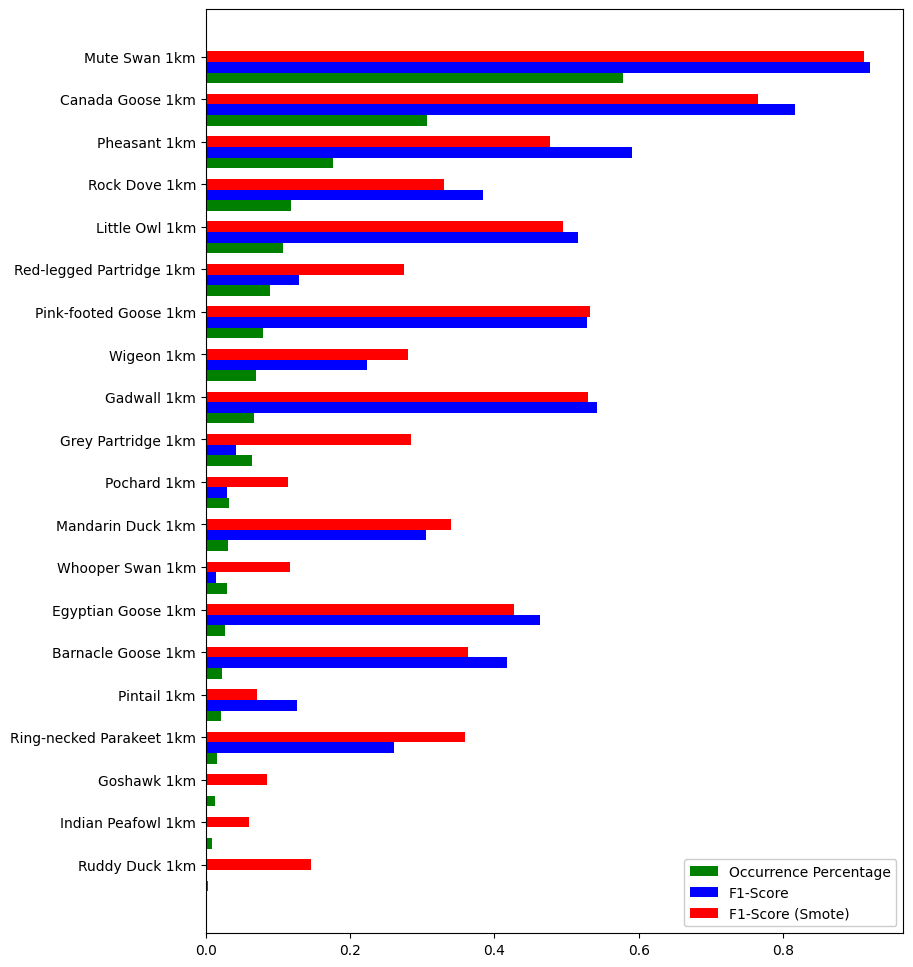

,Labels,F1,F1 (Smote),Occurrence Count,Percentage
9,Mute Swan 1km,0.920603,0.912231,19124,0.578044
1,Canada Goose 1km,0.816094,0.765197,10147,0.306704
10,Pheasant 1km,0.591260,0.476940,5855,0.176974
16,Rock Dove 1km,0.384328,0.330446,3919,0.118456
7,Little Owl 1km,0.516167,0.495392,3548,0.107242
14,Red-legged Partridge 1km,0.128878,0.275000,2953,0.089258
11,Pink-footed Goose 1km,0.527881,0.532582,2646,0.079978
19,Wigeon 1km,0.223164,0.280292,2317,0.070034
3,Gadwall 1km,0.541950,0.530071,2205,0.066649
5,Grey Partridge 1km,0.042403,0.284761,2123,0.064170


In [12]:
# Create graphs to show off data
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [9, 12]

occurrence_count, occurrence_percentage = All_bird_occurrences['Occurrence Count'], All_bird_occurrences['Percentage']
f1 = []
f1_smote = []
labels = []
for dict in df_dicts:
    f1.append(dict['report']['1']['f1-score'])
    f1_smote.append(dict['report_smote']['1']['f1-score'])
    labels.append(dict['name'])



scores = pd.DataFrame({'Labels' : labels, 'F1': f1, 'F1 (Smote)': f1_smote,'Occurrence Count' : occurrence_count, 'Percentage' : occurrence_percentage} )
scores.sort_values('Occurrence Count', inplace=True)

n=20
r = np.arange(n)
height = 0.25

plt.barh(r, 'Percentage', data=scores, label='Occurrence Percentage', height = height, color='g')
plt.barh(r+height, 'F1', data=scores, label='F1-Score',  height= height, color='b')
plt.barh(r+height*2, 'F1 (Smote)', data=scores, label='F1-Score (Smote)',  height = height, color='r')
plt.legend(framealpha=1, frameon=True)
plt.yticks(r+height*2, scores['Labels'])


plt.show()


scores.sort_values('Occurrence Count', ascending=False)

In [23]:
# Export predictions to CSV for QGIS
RESULTS_PATH = 'Datasets/Machine Learning/Results/1km/'
for dict in df_dicts:
    # Join with y_test datafram
    result_df = dict['y_test'] 
    result_df['Predictions'] = dict['predictions_smote']
    display(result_df)
    result_df.to_csv(RESULTS_PATH + dict['name'] + '.csv')
    

,,Occurrence,Predictions
y,x,,
962500.0,155500.0,0,0
819500.0,338500.0,0,0
378500.0,406500.0,0,0
706500.0,390500.0,0,0
897500.0,325500.0,0,0
...,...,...,...
1096500.0,199500.0,0,0
535500.0,591500.0,0,0
337500.0,425500.0,0,0


,,Occurrence,Predictions
y,x,,
836500.0,116500.0,0,0
655500.0,626500.0,0,0
277500.0,451500.0,1,1
518500.0,61500.0,0,0
746500.0,117500.0,0,0
...,...,...,...
1017500.0,557500.0,0,0
374500.0,502500.0,1,0
248500.0,292500.0,0,0


,,Occurrence,Predictions
y,x,,
965500.0,565500.0,0,0
815500.0,297500.0,0,0
357500.0,224500.0,0,0
695500.0,254500.0,0,0
897500.0,689500.0,0,0
...,...,...,...
1097500.0,515500.0,0,0
516500.0,560500.0,0,0
315500.0,568500.0,0,0


,,Occurrence,Predictions
y,x,,
948500.0,472500.0,0,0
799500.0,389500.0,0,0
347500.0,652500.0,0,0
683500.0,615500.0,0,0
880500.0,575500.0,0,0
...,...,...,...
1086500.0,585500.0,0,0
499500.0,640500.0,0,0
312500.0,593500.0,0,0


,,Occurrence,Predictions
y,x,,
968500.0,51500.0,0,0
828500.0,230500.0,0,0
382500.0,480500.0,0,0
718500.0,624500.0,0,0
904500.0,666500.0,0,0
...,...,...,...
1099500.0,552500.0,0,0
540500.0,467500.0,0,0
337500.0,350500.0,0,0


,,Occurrence,Predictions
y,x,,
949500.0,6500.0,0,0
799500.0,470500.0,0,0
361500.0,282500.0,0,0
683500.0,278500.0,1,0
882500.0,446500.0,0,0
...,...,...,...
1091500.0,3500.0,0,0
505500.0,434500.0,0,0
323500.0,642500.0,0,1


,,Occurrence,Predictions
y,x,,
969500.0,180500.0,0,0
824500.0,179500.0,0,0
378500.0,407500.0,0,0
712500.0,336500.0,0,0
903500.0,422500.0,0,0
...,...,...,...
1099500.0,45500.0,0,0
531500.0,276500.0,0,0
334500.0,534500.0,0,0


,,Occurrence,Predictions
y,x,,
930500.0,568500.0,0,0
771500.0,130500.0,0,0
327500.0,11500.0,0,0
645500.0,485500.0,0,0
858500.0,506500.0,0,0
...,...,...,...
1074500.0,258500.0,0,0
456500.0,557500.0,0,0
293500.0,690500.0,0,0


,,Occurrence,Predictions
y,x,,
960500.0,209500.0,0,0
814500.0,197500.0,0,0
367500.0,436500.0,1,1
702500.0,371500.0,0,0
894500.0,360500.0,0,0
...,...,...,...
1096500.0,139500.0,0,0
521500.0,528500.0,0,0
325500.0,88500.0,0,0


,,Occurrence,Predictions
y,x,,
680500.0,65500.0,0,0
530500.0,309500.0,1,1
254500.0,634500.0,1,1
425500.0,348500.0,1,1
626500.0,529500.0,0,0
...,...,...,...
861500.0,205500.0,0,0
322500.0,344500.0,1,1
230500.0,483500.0,1,1


,,Occurrence,Predictions
y,x,,
902500.0,540500.0,0,0
739500.0,369500.0,0,0
317500.0,554500.0,0,1
622500.0,469500.0,0,0
828500.0,584500.0,0,0
...,...,...,...
1057500.0,582500.0,0,0
454500.0,632500.0,0,0
282500.0,318500.0,0,1


,,Occurrence,Predictions
y,x,,
950500.0,406500.0,0,0
809500.0,2500.0,0,0
398500.0,691500.0,0,0
707500.0,615500.0,0,0
881500.0,442500.0,0,0
...,...,...,...
1089500.0,549500.0,0,0
547500.0,154500.0,0,0
354500.0,260500.0,0,0


,,Occurrence,Predictions
y,x,,
967500.0,156500.0,0,1
822500.0,126500.0,0,0
378500.0,457500.0,0,0
709500.0,682500.0,0,0
900500.0,211500.0,0,0
...,...,...,...
1101500.0,468500.0,0,0
532500.0,374500.0,0,0
335500.0,560500.0,0,0


,,Occurrence,Predictions
y,x,,
961500.0,396500.0,0,0
818500.0,565500.0,0,0
371500.0,430500.0,0,1
704500.0,27500.0,0,0
896500.0,597500.0,0,0
...,...,...,...
1094500.0,461500.0,0,0
523500.0,617500.0,0,0
331500.0,11500.0,0,0


,,Occurrence,Predictions
y,x,,
940500.0,272500.0,0,0
782500.0,270500.0,0,0
336500.0,236500.0,0,1
664500.0,453500.0,0,0
868500.0,252500.0,0,0
...,...,...,...
1083500.0,173500.0,0,0
481500.0,553500.0,0,0
299500.0,527500.0,1,0


,,Occurrence,Predictions
y,x,,
969500.0,16500.0,0,0
821500.0,474500.0,0,0
368500.0,295500.0,0,0
709500.0,74500.0,0,0
903500.0,575500.0,0,0
...,...,...,...
1100500.0,390500.0,0,0
529500.0,393500.0,0,0
325500.0,323500.0,0,0


,,Occurrence,Predictions
y,x,,
937500.0,31500.0,0,0
778500.0,202500.0,0,0
335500.0,4500.0,0,0
659500.0,322500.0,1,0
863500.0,259500.0,1,0
...,...,...,...
1080500.0,155500.0,0,0
474500.0,477500.0,1,0
295500.0,95500.0,0,0


,,Occurrence,Predictions
y,x,,
969500.0,293500.0,0,0
825500.0,78500.0,0,0
379500.0,633500.0,0,0
713500.0,366500.0,0,0
901500.0,154500.0,0,0
...,...,...,...
1099500.0,316500.0,0,0
532500.0,141500.0,0,0
336500.0,138500.0,0,0


,,Occurrence,Predictions
y,x,,
965500.0,325500.0,1,0
825500.0,144500.0,1,0
386500.0,276500.0,0,1
713500.0,82500.0,0,0
903500.0,171500.0,0,0
...,...,...,...
1095500.0,145500.0,0,0
537500.0,428500.0,0,0
343500.0,467500.0,0,0


,,Occurrence,Predictions
y,x,,
952500.0,101500.0,0,0
810500.0,233500.0,0,0
374500.0,364500.0,1,1
698500.0,209500.0,0,0
884500.0,398500.0,0,0
...,...,...,...
1086500.0,454500.0,0,0
527500.0,207500.0,0,1
333500.0,528500.0,0,0
